In [12]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

import seaborn as sns
sns.set_theme(style="whitegrid")

load_dotenv(override=True)
SQLALCHEMY_DATABASE_URI = os.getenv("DATABASE_URL")


from prophet import Prophet
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric, plot_yearly
from prophet.diagnostics import cross_validation, performance_metrics

In [13]:
# Create an engine instance
alchemyEngine = create_engine(SQLALCHEMY_DATABASE_URI)
# Connect to PostgreSQL server

dbConnection = alchemyEngine.connect()
# Read data from PostgreSQL database table and load into a DataFrame instance

df_objet_perdu = pd.read_sql("select * from \"objet_perdu\"", dbConnection)
dbConnection.close()

In [14]:
df_objet_perdu["date"] = df_objet_perdu["date"].dt.strftime('%Y-%m-%d')

In [15]:
df = df_objet_perdu.groupby(['date'])['id'].count().reset_index().rename(columns ={'date':'ds', 'id':'y'})
df

,ds,y
0,2013-11-01,5
1,2013-11-02,15
2,2013-11-03,6
3,2013-11-04,15
4,2013-11-05,20
...,...,...
3231,2023-01-01,4
3232,2023-01-02,9
3233,2023-01-03,7
3234,2023-01-04,6


In [16]:
train = df.drop(df.index[-5:])
test = df.drop(df.index[:-5])
print(train.tail())
print(test)

              ds   y
3226  2022-12-27   2
3227  2022-12-28   4
3228  2022-12-29  13
3229  2022-12-30  10
3230  2022-12-31   5
              ds   y
3231  2023-01-01   4
3232  2023-01-02   9
3233  2023-01-03   7
3234  2023-01-04   6
3235  2023-01-05  12


In [17]:
m = Prophet()
m.fit(train)

09:06:54 - cmdstanpy - INFO - Chain [1] start processing
09:06:56 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')


  0%|          | 0/13 [00:00<?, ?it/s]09:06:57 - cmdstanpy - INFO - Chain [1] start processing
09:06:58 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 1/13 [00:02<00:35,  2.97s/it]09:07:00 - cmdstanpy - INFO - Chain [1] start processing
09:07:01 - cmdstanpy - INFO - Chain [1] done processing
 15%|█▌        | 2/13 [00:06<00:37,  3.39s/it]09:07:05 - cmdstanpy - INFO - Chain [1] start processing
09:07:05 - cmdstanpy - INFO - Chain [1] done processing
 23%|██▎       | 3/13 [00:11<00:38,  3.89s/it]09:07:09 - cmdstanpy - INFO - Chain [1] start processing
09:07:10 - cmdstanpy - INFO - Chain [1] done processing
 31%|███       | 4/13 [00:15<00:35,  3.95s/it]09:07:13 - cmdstanpy - INFO - Chain [1] start processing
09:07:13 - cmdstanpy - INFO - Chain [1] done processing
 38%|███▊      | 5/13 [00:18<00:29,  3.74s/it]09:07:17 - cmdstanpy - INFO - Chain [1] start processing
09:07:18 - cmdstanpy - INFO - Chain [1] done processing
 46%|████▌     | 6/13 [00:24<00:30,  4.36s/it]09:07:23

In [19]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-02-02,12.427426,6.457463,18.735268,11,2016-02-01
1,2016-02-03,11.751358,5.477822,17.792283,7,2016-02-01
2,2016-02-04,13.318417,6.610732,19.215348,14,2016-02-01
3,2016-02-05,12.791156,6.573407,19.081299,11,2016-02-01
4,2016-02-06,13.410864,7.481504,19.013611,12,2016-02-01


In [20]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,18.833437,4.339751,3.379195,0.578657,0.345287,0.442895,0.840197
1,37 days,18.624402,4.315600,3.360984,0.579319,0.344821,0.442686,0.840878
2,38 days,17.786855,4.217446,3.299264,0.573553,0.344306,0.440232,0.849217
3,39 days,17.514781,4.185066,3.271856,0.557258,0.341015,0.434945,0.850749
4,40 days,17.414305,4.173045,3.258263,0.539461,0.340066,0.430993,0.849047


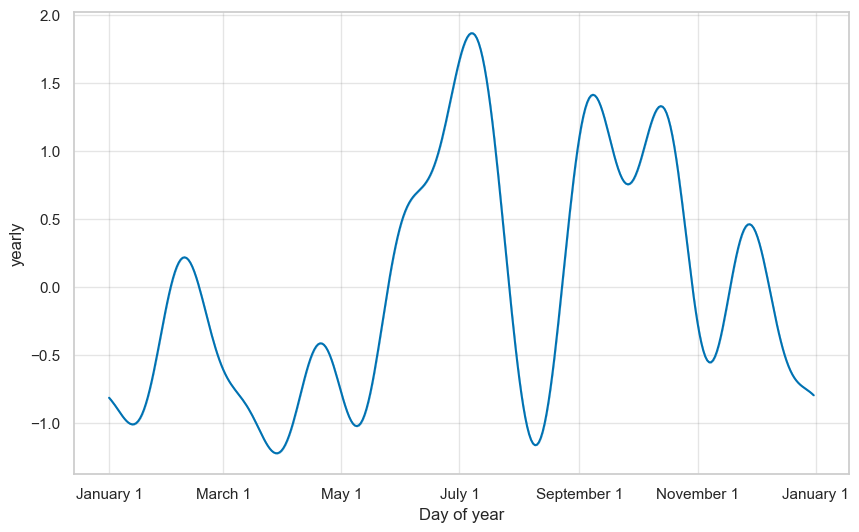

In [21]:
a = plot_yearly(m)

In [22]:
future = m.make_future_dataframe(periods=5, freq='D')
future.tail()

,ds
3231,2023-01-01
3232,2023-01-02
3233,2023-01-03
3234,2023-01-04
3235,2023-01-05


In [23]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


,ds,yhat,yhat_lower,yhat_upper
0,2013-11-01,10.420197,4.501068,16.319586
1,2013-11-02,10.296150,4.567915,15.834036
2,2013-11-03,8.163489,2.475765,13.687710
3,2013-11-04,12.167258,6.324075,17.623301
4,2013-11-05,10.031375,4.078717,15.834055
...,...,...,...,...
3231,2023-01-01,5.173394,-0.102626,10.551864
3232,2023-01-02,9.221080,3.460260,14.529678
3233,2023-01-03,7.113810,1.710828,12.908142
3234,2023-01-04,6.432039,0.443440,12.068049


In [32]:
forecast.values.tolist()

[[Timestamp('2013-11-01 00:00:00'),
  10.575267,
  4.501067703542328,
  16.319586498901522,
  10.575267,
  10.575267,
  -0.15507009313456382,
  -0.15507009313456382,
  -0.15507009313456382,
  0.10954398391373854,
  0.10954398391373854,
  0.10954398391373854,
  -0.26461407704830237,
  -0.26461407704830237,
  -0.26461407704830237,
  0.0,
  0.0,
  0.0,
  10.420196906865437],
 [Timestamp('2013-11-02 00:00:00'),
  10.576407705049297,
  4.567914923172078,
  15.834035892767778,
  10.576407705049297,
  10.576407705049297,
  -0.2802577612442495,
  -0.2802577612442495,
  -0.2802577612442495,
  0.06543647660481254,
  0.06543647660481254,
  0.06543647660481254,
  -0.34569423784906206,
  -0.34569423784906206,
  -0.34569423784906206,
  0.0,
  0.0,
  0.0,
  10.296149943805048],
 [Timestamp('2013-11-03 00:00:00'),
  10.577548410098595,
  2.475765399457623,
  13.68770957283347,
  10.577548410098595,
  10.577548410098595,
  -2.4140595214064726,
  -2.4140595214064726,
  -2.4140595214064726,
  -1.99922179

In [24]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3231,2023-01-01,7.981692,-0.102626,10.551864,7.981692,7.981692,-2.808298,-2.808298,-2.808298,-1.999222,-1.999222,-1.999222,-0.809076,-0.809076,-0.809076,0.0,0.0,0.0,5.173394
3232,2023-01-02,7.986469,3.460260,14.529678,7.986469,7.986469,1.234611,1.234611,1.234611,2.059600,2.059600,2.059600,-0.824989,-0.824989,-0.824989,0.0,0.0,0.0,9.221080
3233,2023-01-03,7.991247,1.710828,12.908142,7.991247,7.991247,-0.877437,-0.877437,-0.877437,-0.034918,-0.034918,-0.034918,-0.842519,-0.842519,-0.842519,0.0,0.0,0.0,7.113810
3234,2023-01-04,7.996024,0.443440,12.068049,7.996024,7.996024,-1.563985,-1.563985,-1.563985,-0.702495,-0.702495,-0.702495,-0.861490,-0.861490,-0.861490,0.0,0.0,0.0,6.432039
3235,2023-01-05,8.000801,1.993860,13.480923,8.000801,8.000801,-0.379539,-0.379539,-0.379539,0.502054,0.502054,0.502054,-0.881593,-0.881593,-0.881593,0.0,0.0,0.0,7.621263


In [25]:
test

,ds,y
3231,2023-01-01,4
3232,2023-01-02,9
3233,2023-01-03,7
3234,2023-01-04,6
3235,2023-01-05,12


In [26]:
y_true = test['y']
y_pred = forecast['yhat'].tail()
mae = mean_absolute_error(y_true, y_pred)

MAE: 1.264


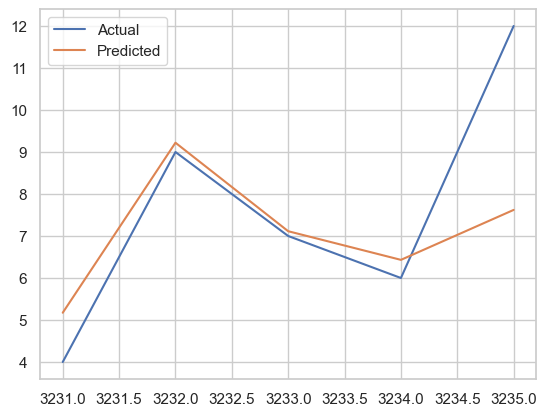

In [27]:
print('MAE: %.3f' % mae)
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

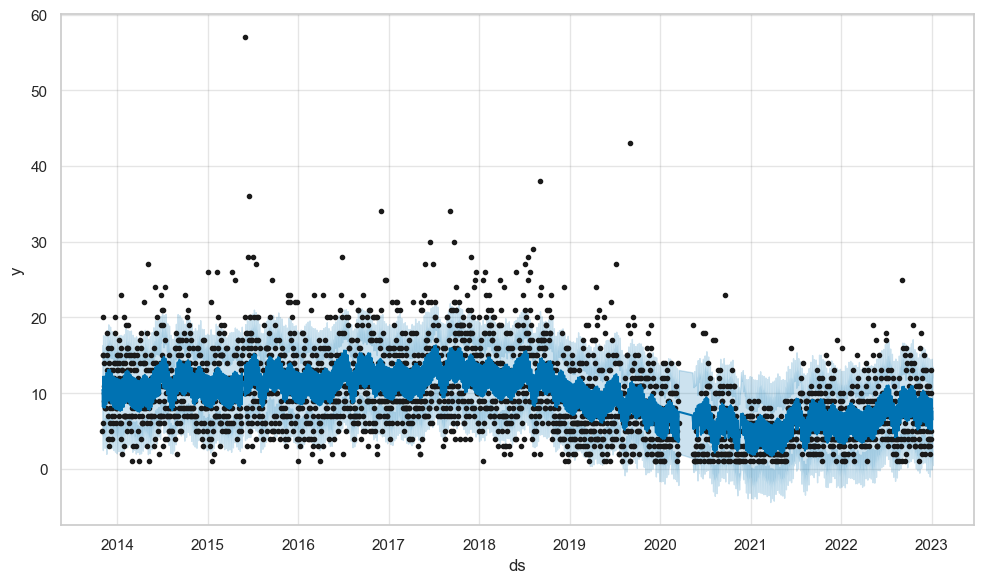

In [28]:
fig1 = m.plot(forecast, uncertainty=True)

In [29]:
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

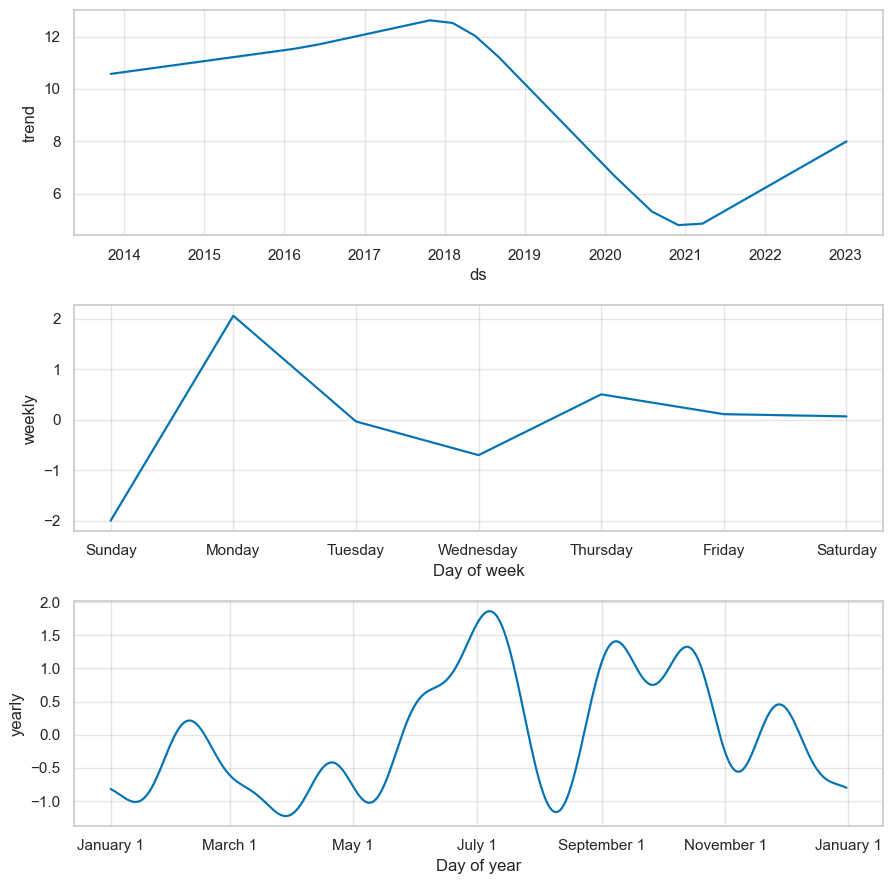

In [30]:
fig2 = m.plot_components(forecast)